# Query 5
0. Exact result
1. Stratified sampling
2. Weighted KDE
3. Analysis based on regions

In [ ]:
select
	n_name,
	sum(l_extendedprice * (1 - l_discount)) as revenue
from
	customer,
	orders,
	lineitem,
	supplier,
	nation,
	region
where
	c_custkey = o_custkey
	and l_orderkey = o_orderkey
	and l_suppkey = s_suppkey
	and c_nationkey = s_nationkey
	and s_nationkey = n_nationkey
	and n_regionkey = r_regionkey
	and r_name = ':1'
	and o_orderdate >= date ':2'
	and o_orderdate < date ':2' + interval '1' year
group by
	n_name
order by
	revenue desc;

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from distutils.version import LooseVersion

from collections import Counter

import scipy
from scipy.stats import gaussian_kde
from scipy import integrate

import timeit
import pickle
from datetime import date, timedelta
import sys
import scipy.stats as st
from random import random

In [2]:
import pyspark
import pyspark.sql
from pyspark.sql import *
import pyspark.sql.functions as f
from pyspark.sql.functions import col

from pyspark import broadcast
# To avoid OverflowError: cannot serialize a string larger than 4GiB
def broadcast_dump(self, value, f):
    pickle.dump(value, f, 4)  # was 2, 4 is first protocol supporting >4GB
    f.close()
    return f.name
broadcast.Broadcast.dump = broadcast_dump

conf = pyspark.SparkConf().setMaster("local[16]").setAll([
                                   ('spark.executor.memory', '4g'),  # find
                                   ('spark.driver.memory','10g'), # your
                                   ('spark.driver.maxResultSize', '4G') # setup
                                  ])
# create the session
spark = SparkSession.builder.config(conf=conf).getOrCreate()

# create the context
sc = spark.sparkContext

# FIX for Spark 2.x
locale = sc._jvm.java.util.Locale
locale.setDefault(locale.forLanguageTag("en-US"))

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [4]:
import stratified_sampling

In [5]:
lineitem = spark.read.parquet("/Users/futongliu/Downloads/SemesterProject/tpch_parquet_sf1/lineitem.parquet")#.limit(3000)
nation = spark.read.parquet("/Users/futongliu/Downloads/SemesterProject/tpch_parquet_sf1/nation.parquet")#.limit(3000)
region = spark.read.parquet("/Users/futongliu/Downloads/SemesterProject/tpch_parquet_sf1/region.parquet")#.limit(3000)
customer = spark.read.parquet("/Users/futongliu/Downloads/SemesterProject/tpch_parquet_sf1/customer.parquet")#.limit(3000)
orders = spark.read.parquet("/Users/futongliu/Downloads/SemesterProject/tpch_parquet_sf1/order.parquet")#.limit(3000)
supplier = spark.read.parquet("/Users/futongliu/Downloads/SemesterProject/tpch_parquet_sf1/supplier.parquet")#.limit(3000)

### Helper Functions

In [6]:
def calculate_error(Q1_approx, Q1_exact):
    df_2 = Q1_approx.toPandas().set_index(['n_name']).astype(float)
    df_1 = Q1_exact.toPandas().set_index(['n_name']).astype(float)
    return abs(df_2 - df_1) * 100 / df_1

def calculate_size_of(obj):
    p = pickle.dumps(obj)
    size = sys.getsizeof(p)
    print('The size of the object in MB: ', size / 2 ** 20)
    return size

In [7]:
REGION_NAMES = region.select('r_name').distinct().toPandas().r_name.values

In [8]:
REGION_NAME = 'AMERICA'
THE_DATE = date(1995, 6, 20)
QCS = ['r_name', 'o_orderdate', 'n_name']

In [9]:
CONSTRUCTION_TIME = [0] * 2
EXECUTION_TIME = [0] * 2
SPACE = [0] * 2
ERROR = [0] * 2

# 0. Exact Result

In [10]:
df = customer.join(orders, customer.c_custkey == orders.o_custkey)\
            .join(lineitem, lineitem.l_orderkey == orders.o_orderkey)\
            .join(supplier, (lineitem.l_suppkey == supplier.s_suppkey) & (customer.c_nationkey == supplier.s_nationkey))\
            .join(nation, supplier.s_nationkey == nation.n_nationkey)\
            .join(region, nation.n_regionkey == region.r_regionkey)

In [11]:
def compute_exact_result(df, region_name, the_date):
    return df.where(df.r_name == region_name)\
            .where( (the_date <= f.col("o_orderdate")) & (f.col("o_orderdate") < the_date + timedelta(days = 365)))\
            .groupby("n_name")\
            .agg(f.sum(col('l_extendedprice') * (1 - col('l_discount'))).alias('revenue'))\
            .sort("revenue", ascending = False)
    
start = timeit.default_timer()
exact_result = compute_exact_result(df, REGION_NAME, THE_DATE)
exact_result.show()
stop = timeit.default_timer()
print('Exact query execution time: ', stop-start)

+-------------+-------------+
|       n_name|      revenue|
+-------------+-------------+
|    ARGENTINA|56029331.1951|
|         PERU|54089144.1469|
|       CANADA|53544241.6835|
|UNITED STATES|52749687.0780|
|       BRAZIL|49761701.3594|
+-------------+-------------+

Exact query execution time:  7.292901909999998


# 1. Stratified Sampling
## 1.1. Construction

In [12]:
start = timeit.default_timer()
sample_df = stratified_sampling.generate_stratified_sample(df, QCS, 0.01, 0.99).cache()
count_df = df.groupby(QCS).count(); sample_df.count()
stop = timeit.default_timer()
CONSTRUCTION_TIME[0] = stop - start
print('Construction time is ', stop - start)

maxStrataSize:  18 minStrataSize:  2.0 midStrataSize:  10.0
Estimated error with bisection:  23133211.433972567 User defined error bound 9187722498.97
maxStrataSize:  10.0 minStrataSize:  2.0 midStrataSize:  6.0
Estimated error with bisection:  24263880.65662764 User defined error bound 9187722498.97
maxStrataSize:  6.0 minStrataSize:  2.0 midStrataSize:  4.0
Estimated error with bisection:  27628160.67680309 User defined error bound 9187722498.97
maxStrataSize:  4.0 minStrataSize:  2.0 midStrataSize:  3.0
Estimated error with bisection:  31411640.06318288 User defined error bound 9187722498.97
Construction time is  73.18421978099991


In [13]:
sample_df.write.parquet('./pickles/Q5_sampleDF')
count_df.write.parquet('./pickles/Q5_countDF')

### Space

In [14]:
SPACE[0] = calculate_size_of(sample_df.toPandas()) + calculate_size_of(count_df.toPandas())

The size of the object in MB:  138.87238121032715
The size of the object in MB:  3.9030189514160156


## 1.2. Execution


In [16]:
def compute_approximate_result(sample_df, count_df, region_name, the_date):
    count_df_ = count_df.where(f.col('r_name') == region_name)\
            .where( (the_date <= f.col("o_orderdate")) & (f.col("o_orderdate") < the_date + timedelta(days = 365)))\
            .groupby('n_name').sum()
    
    sample_df_avg = sample_df.where(f.col('r_name') == region_name)\
            .where( (the_date <= f.col("o_orderdate")) & (f.col("o_orderdate") < the_date + timedelta(days = 365)))\
            .groupby('n_name')\
            .agg(f.avg(col('l_extendedprice') * (1 - col('l_discount'))).alias('revenue_avg'))\
            .join(count_df_, 'n_name')
    
    return sample_df_avg.withColumn('revenue', f.col('revenue_avg') * f.col('sum(count)') )\
            .select(['n_name', 'revenue']).sort("revenue", ascending = False)


### Execution Time

In [35]:
start = timeit.default_timer()
sample_result = compute_approximate_result(sample_df, count_df, REGION_NAME, THE_DATE).cache(); sample_result.show()
stop = timeit.default_timer()
EXECUTION_TIME[0] = stop - start
print('Execution time is ', stop - start)

+-------------+---------------+
|       n_name|        revenue|
+-------------+---------------+
|    ARGENTINA|55671122.132080|
|       CANADA|53663976.370541|
|         PERU|52676036.106876|
|UNITED STATES|51979218.377824|
|       BRAZIL|49874503.590009|
+-------------+---------------+

Execution time is  0.14293764600006398


### Error

In [18]:
sample_error = calculate_error(sample_result, exact_result)
sample_error

,revenue
n_name,
ARGENTINA,0.639324
BRAZIL,0.226685
CANADA,0.223618
PERU,2.612554
UNITED STATES,1.460613


In [20]:
ERROR[0] = sample_error.mean()[0], sample_error.std()[0]
ERROR[0]

(1.0325587951615405, 1.017111830001076)

# 2. Weighted-KDE
## 2.1. Cleaning and Normalization

In [17]:
df_clean = df.withColumn('l_shipdate', f.to_date('l_shipdate', 'yyyy-MM-dd'))\
                .withColumn('l_extendedprice', f.col('l_extendedprice').cast('float'))\
                .withColumn('l_discount', f.col('l_discount').cast('float'))

In [18]:
transform, i_transform = {}, {}
normalize = {}

START_DATE = df_clean.select(f.min('o_orderdate')).first()[0]
END_DATE = df_clean.select(f.max('o_orderdate')).first()[0]
normalize['date'] = (START_DATE, END_DATE)
def lambda_normalize_date(x):
    transformed_date = -1 + 2 * (x - normalize['date'][0]).days / (normalize['date'][1] - normalize['date'][0]).days
    if transformed_date < -1: return -1
    elif transformed_date > 1: return 1
    else: return transformed_date
transform['date'] = lambda_normalize_date

In [19]:
def compute_kdes(s_values, bw='scott'):
    '''
    Compute the KDE given the block that is already grouped by key 
    s_values[0]: stratum_str
    s_values[1]: iterable block of rows that is identified by this stratum_str
    '''
    stratum_str, iterable_rows = s_values[0], s_values[1]
    kdes_bank = dict()
    
    # Training Data
    X_orderdate = []
    X_revenue = []
    
    # Fill in the training data
    for row in iterable_rows:
        X_orderdate.append(transform['date'](row['o_orderdate']))
        X_revenue.append(row['revenue'])
        
    # Store the trained model into the KDE bank
    kdes_bank['revenue'] = gaussian_kde(X_orderdate, bw_method=bw, weights = X_revenue)
    kdes_bank['revenue_sum'] = np.sum(X_revenue)
    
    stra_list = stratum_str.split("_")
    return stra_list + [stratum_str, kdes_bank]

In [20]:
def kde_based_method_construction(lineitem_clean):
    strat_kde = lineitem_clean.groupby('n_name', 'r_name', 'o_orderdate')\
            .agg(f.sum(col('l_extendedprice') * (1 - col('l_discount'))).alias('revenue')).rdd\
            .map(lambda row: ("_".join([row['n_name'], row['r_name']]), row)).groupByKey()\
            .map(compute_kdes)
    # (RDD) strat_kde: flag, status, stratum_str, kdes_bank
    
    hashMap_kde = {stratum_str: kde for stratum_str, kde in strat_kde.map(lambda row: (row[-2], row[-1])).collect()}
    # hashMap_kde: stratum_string -> Actual Kernel Density Estimation Models that corresponds to this stratum
    # The last two items are: stratum_str(-2), kdes_bank(-1)
    
    strata_catalogue = strat_kde.map(lambda row: row[:3]).toDF(['n_name', 'r_name', 'stratum_str'])
    # (DF) strata_catalogue: flag, status, date, stratum_str
    return strata_catalogue, hashMap_kde

## 2.2 Construction

In [21]:
start = timeit.default_timer()
strata_catalogue, hashMap_kde = kde_based_method_construction(df_clean)
strata_catalogue = strata_catalogue.cache(); strata_catalogue.show()
stop = timeit.default_timer()
CONSTRUCTION_TIME[1] = stop - start
print(stop - start)

+-------------+-----------+--------------------+
|       n_name|     r_name|         stratum_str|
+-------------+-----------+--------------------+
|      MOROCCO|     AFRICA|      MOROCCO_AFRICA|
| SAUDI ARABIA|MIDDLE EAST|SAUDI ARABIA_MIDD...|
|       CANADA|    AMERICA|      CANADA_AMERICA|
|   MOZAMBIQUE|     AFRICA|   MOZAMBIQUE_AFRICA|
|      GERMANY|     EUROPE|      GERMANY_EUROPE|
|        INDIA|       ASIA|          INDIA_ASIA|
|    ARGENTINA|    AMERICA|   ARGENTINA_AMERICA|
|        KENYA|     AFRICA|        KENYA_AFRICA|
|      ROMANIA|     EUROPE|      ROMANIA_EUROPE|
|       JORDAN|MIDDLE EAST|  JORDAN_MIDDLE EAST|
|     ETHIOPIA|     AFRICA|     ETHIOPIA_AFRICA|
|         IRAN|MIDDLE EAST|    IRAN_MIDDLE EAST|
|         IRAQ|MIDDLE EAST|    IRAQ_MIDDLE EAST|
|        EGYPT|MIDDLE EAST|   EGYPT_MIDDLE EAST|
|      VIETNAM|       ASIA|        VIETNAM_ASIA|
|    INDONESIA|       ASIA|      INDONESIA_ASIA|
|UNITED STATES|    AMERICA|UNITED STATES_AME...|
|       BRAZIL|    A

In [22]:
strata_catalogue.count()

25

### Space

In [72]:
SPACE[1] = calculate_size_of(strata_catalogue.toPandas()) + calculate_size_of(hashMap_kde)

The size of the object in MB:  0.0019712448120117188
The size of the object in MB:  0.9099712371826172


956241

## 2.3. Testing

In [23]:
def kde_based_cal_result(row, the_date, bw):
    '''
    Compute the result with the KDE models
    
    row: a row in RDD
    '''
    revenue = 0
    l_date, r_date = transform['date'](the_date), transform['date'](the_date + timedelta(days = 365))
    kde_bank = hashMap_kde[row['stratum_str']]
    
    kde_revenue = kde_bank['revenue']; kde_revenue.set_bandwidth(bw)
    revenue = kde_bank['revenue_sum'] * kde_revenue.integrate_box_1d(l_date, r_date)
    
    return (row['n_name'], row['r_name'], float(revenue))

In [24]:
def kde_based_method_testing(strata_catalogue, region_name, the_date, bw = 'scott'):
    '''
    Args:
        strata_catalogue: pre-saved DF with schema: flag, status, stratum_str
        hashMap_kde: stratum_string -> Actual Kernel Density Estimation Models that corresponds to this stratum
        left_date, right_date: datetime objects
    Return:
        Q1_kde_approx: A dataframe of pySpark
    '''
    
    Q1_kde_approx = strata_catalogue.rdd.map(lambda x: kde_based_cal_result(x, the_date, bw))\
    .toDF(['n_name', 'r_name', 'revenue']).where(f.col('r_name') == region_name)\
    .select('n_name', 'revenue')\
    .sort('revenue', ascending = False)
    
    return Q1_kde_approx

### Execution

In [25]:
start = timeit.default_timer()
weighed_kde_result = kde_based_method_testing(strata_catalogue, REGION_NAME, THE_DATE, .1).cache(); weighed_kde_result.show()
stop = timeit.default_timer()
EXECUTION_TIME[1] = stop - start
print('Execution time is', stop - start)

+-------------+--------------------+
|       n_name|             revenue|
+-------------+--------------------+
|    ARGENTINA| 5.481726686670805E7|
|       CANADA|5.4303456242637135E7|
|         PERU|5.4254683976108514E7|
|UNITED STATES|5.2801917522587284E7|
|       BRAZIL| 5.059944451721059E7|
+-------------+--------------------+

Execution time is 2.6595729449999936


### Error

In [26]:
weighted_kde_error = calculate_error(weighed_kde_result, exact_result)
ERROR[1] = (weighted_kde_error.mean(), weighted_kde_error.mean())

In [27]:
weighted_kde_error.mean()

revenue    1.133953
dtype: float64

# 3. Comparison of execution time and Accuracy
There are two params that's changeable here in this query 5, region name and order date.

In [34]:
def evalute_by_r_name():
    error_bank, execution_time = [], []

    for r_name in REGION_NAMES:
        
        # Exact
        start = timeit.default_timer()
        exact_result = compute_exact_result(df, r_name, THE_DATE); exact_result.count()
        stop = timeit.default_timer()
        exact_time = stop-start

        # Stratified Sampling
        start = timeit.default_timer()
        sample_df = spark.read.parquet('./pickles/Q5_sampleDF')
        count_df = spark.read.parquet('./pickles/Q5_countDF')
        sample_result = compute_approximate_result(sample_df, count_df, r_name, THE_DATE); sample_result.count()
        stop = timeit.default_timer()
        samp_time = stop - start
        
        samp_error = calculate_error(sample_result, exact_result)
        samp_error = (samp_error.mean()[0], samp_error.mean()[0])


        # KDE-based
        start = timeit.default_timer()
        weighted_kde_result = kde_based_method_testing(strata_catalogue, r_name, THE_DATE, 'scott').cache(); weighted_kde_result.count()
        stop = timeit.default_timer()
        kde_time = stop - start
        
        kde_error = calculate_error(weighted_kde_result, exact_result)
        kde_error = (kde_error.mean()[0], kde_error.mean()[0])
        
        execution_time.append([exact_time, samp_time, kde_time])
        error_bank.append([samp_error, kde_error])
        
    return execution_time, error_bank

In [35]:
execution_time, error_bank = evalute_by_r_name()

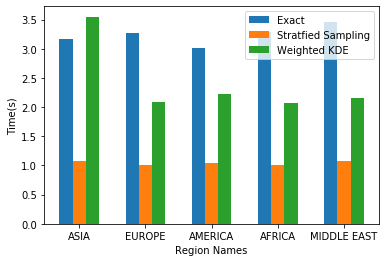

In [42]:
# Time
plt.figure(figsize=(6, 4))

ind = np.arange(len(REGION_NAMES))  # the x locations for the groups
width = 0.2  # the width of the bars

plt.bar(ind - width, np.array(execution_time)[:,0], width, label='Exact')
plt.bar(ind, np.array(execution_time)[:,1], width, label='Stratfied Sampling')
plt.bar(ind + width, np.array(execution_time)[:,2], width, label='Weighted KDE')

plt.legend()
plt.xticks(ind, REGION_NAMES)
plt.xlabel('Region Names')
plt.ylabel('Time(s)')
plt.savefig('./figs/q5_time_region.png')

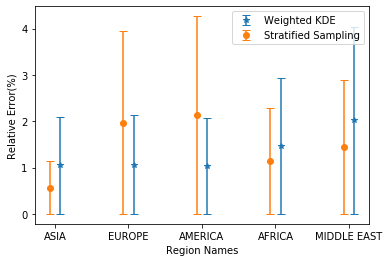

In [41]:
plt.figure(figsize=(6, 4))
plt.errorbar(ind + .07, [s[0] for s, k in error_bank], yerr=[s[1] for s, k in error_bank],\
             fmt='*', capsize=4, label='Weighted KDE')
plt.errorbar(ind - .07, [k[0] for s, k in error_bank], yerr=[k[1] for s, k in error_bank],\
             fmt='o', capsize=4, label='Stratified Sampling')
plt.legend()
plt.xticks(ind, REGION_NAMES)
plt.xlabel('Region Names')
plt.ylabel('Relative Error(%)')
plt.savefig('./figs/q5_error_region.png')